In [85]:
#Import Libraries
import pandas as pd
import numpy as np
from attention import Attention
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, LSTM, Dense, TimeDistributed, Conv1D, MaxPooling1D, Dropout, Flatten, RepeatVector
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import regularizers
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import l2
import tensorflow_addons as tfa
from imblearn.over_sampling import SMOTE

from keras.layers import Attention
from imblearn.over_sampling import SMOTE


In [5]:
# Load the dataset
data = pd.read_csv("/home/disi/ff/Datasets/Dataset_1/forcasting.csv")

In [6]:
data['created_at'] = pd.to_datetime(data['created_at'])
data = data.sort_values(by='created_at')
forecast_cols = ['humidity (%)', 'temperature (DegCel)', 'light intensity']
df_forecast = data[forecast_cols]
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_forecast)

In [7]:
def create_sequences(data, input_seq_length, output_seq_length):
    X, y = [], []
    for i in range(len(data) - input_seq_length - output_seq_length + 1):
        seq_x = data[i:i + input_seq_length]
        seq_y = data[i + input_seq_length:i + input_seq_length + output_seq_length]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

input_seq_length = 10
features = 3
output_seq_length = 5
X, y = create_sequences(scaled_data, input_seq_length, output_seq_length)
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

K.clear_session()

input_layer = Input(shape=(input_seq_length, features))

In [69]:
# Assuming each sequence has a length of 10 and 3 features
X_train = np.random.randn(1000, 10, 3)
y_train = np.random.randint(2, size=1000)  # 0s and 1s
X_test = np.random.randn(350, 10, 3)
y_test = np.random.randint(2, size=350)  # 0s and 1s

# 1. Building the LSTM with Attention Model
sequence_length = 10
num_features = 3

input_layer = Input(shape=(sequence_length, num_features))

# LSTM layers
x = LSTM(50, return_sequences=True)(input_layer)
x = Dropout(0.25)(x)

# Attention layer
query = LSTM(50, return_sequences=True)(x)
value = LSTM(50, return_sequences=True)(x)
x = Attention()([query, value])

x = Flatten()(x)
x = Dense(50, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

model.summary()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_16 (InputLayer)       [(None, 10, 3)]              0         []                            
                                                                                                  
 lstm_46 (LSTM)              (None, 10, 50)               10800     ['input_16[0][0]']            
                                                                                                  
 dropout_16 (Dropout)        (None, 10, 50)               0         ['lstm_46[0][0]']             
                                                                                                  
 lstm_47 (LSTM)              (None, 10, 50)               20200     ['dropout_16[0][0]']          
                                                                                           

In [70]:
# 2. Adaptive Sampling
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_train.reshape(-1, sequence_length * num_features), y_train)
X_resampled = X_resampled.reshape(-1, sequence_length, num_features)

In [71]:
# 3. Training the Model
history = model.fit(X_resampled, y_resampled, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=1)


Epoch 1/100


W0000 00:00:1702461314.291573   37821 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "111" frequency: 2593 num_cores: 6 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 36700160 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


32/32 [==============================] - 6s 41ms/step - loss: 0.2500 - accuracy: 0.5248 - val_loss: 0.2505 - val_accuracy: 0.5200
Epoch 2/100


W0000 00:00:1702461316.005785   37821 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "111" frequency: 2593 num_cores: 6 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 36700160 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


32/32 [==============================] - 0s 9ms/step - loss: 0.2498 - accuracy: 0.5248 - val_loss: 0.2512 - val_accuracy: 0.4971
Epoch 3/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2496 - accuracy: 0.5228 - val_loss: 0.2520 - val_accuracy: 0.4771
Epoch 4/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2488 - accuracy: 0.5367 - val_loss: 0.2516 - val_accuracy: 0.4914
Epoch 5/100
32/32 [==============================] - 0s 9ms/step - loss: 0.2480 - accuracy: 0.5387 - val_loss: 0.2531 - val_accuracy: 0.5143
Epoch 6/100
32/32 [==============================] - 0s 10ms/step - loss: 0.2482 - accuracy: 0.5476 - val_loss: 0.2496 - val_accuracy: 0.5000
Epoch 7/100
32/32 [==============================] - 0s 10ms/step - loss: 0.2479 - accuracy: 0.5298 - val_loss: 0.2529 - val_accuracy: 0.5029
Epoch 8/100
32/32 [==============================] - 0s 11ms/step - loss: 0.2464 - accuracy: 0.5407 - val_loss: 0.2498 - val_accuracy: 0.5143
Epoch 9/100
32/32 [===

In [72]:
# 4. Anomaly Detection
predictions = model.predict(X_test)
anomalies = (predictions > 0.3).astype(int)

print("Predicted Anomalies:", anomalies)

11/11 [==============================] - 1s 3ms/step
Predicted Anomalies: [[0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 

W0000 00:00:1702461350.703637   37821 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "111" frequency: 2593 num_cores: 6 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 36700160 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


In [73]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=1)


Epoch 1/100


32/32 [==============================] - 0s 14ms/step - loss: 0.0562 - accuracy: 0.9310 - val_loss: 0.4185 - val_accuracy: 0.4343
Epoch 2/100
32/32 [==============================] - 0s 10ms/step - loss: 0.0566 - accuracy: 0.9270 - val_loss: 0.4273 - val_accuracy: 0.4657
Epoch 3/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0612 - accuracy: 0.9160 - val_loss: 0.4320 - val_accuracy: 0.4571
Epoch 4/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0508 - accuracy: 0.9360 - val_loss: 0.4221 - val_accuracy: 0.4657
Epoch 5/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0558 - accuracy: 0.9360 - val_loss: 0.4170 - val_accuracy: 0.4714
Epoch 6/100
32/32 [==============================] - 0s 11ms/step - loss: 0.0531 - accuracy: 0.9410 - val_loss: 0.4378 - val_accuracy: 0.4543
Epoch 7/100
32/32 [==============================] - 0s 10ms/step - loss: 0.0440 - accuracy: 0.9490 - val_loss: 0.4297 - val_accuracy: 0.4771
Epoch 8/100
32/32 [==

In [74]:
# Make predictions
y_pred = model.predict(X_test)

# Flatten the predictions and true values for simplicity
y_true_flat = y_test.flatten()
y_pred_flat = y_pred.flatten()

 1/11 [=>............................] - ETA: 0s

11/11 [==============================] - 0s 3ms/step


In [75]:
# Calculate MAE, RMSE, and MAPE
mae = mean_absolute_error(y_true_flat, y_pred_flat)
rmse = np.sqrt(mean_squared_error(y_true_flat, y_pred_flat))
mape = np.mean(np.abs((y_true_flat - y_pred_flat) / y_true_flat)) * 100

/tmp/ipykernel_37821/2936188768.py:4: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_true_flat - y_pred_flat) / y_true_flat)) * 100


In [77]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, precision_score, recall_score, f1_score


# Make predictions
y_pred = model.predict(X_test)

# Flatten the predictions and true values for simplicity
y_true_flat = y_test.flatten()
y_pred_flat = y_pred.flatten()

# Calculate MAE, RMSE, and MAPE
mae = mean_absolute_error(y_true_flat, y_pred_flat)
rmse = np.sqrt(mean_squared_error(y_true_flat, y_pred_flat))
mape = np.mean(np.abs((y_true_flat - y_pred_flat) / y_true_flat)) * 100

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}%")

 1/11 [=>............................] - ETA: 0s

11/11 [==============================] - 0s 4ms/step
MAE: 0.49351430513440486
RMSE: 0.6658453954857615
MAPE: inf%


/tmp/ipykernel_37821/3031672489.py:14: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_true_flat - y_pred_flat) / y_true_flat)) * 100


 1/11 [=>............................] - ETA: 0s - loss: 0.5186 - accuracy: 0.4688

11/11 [==============================] - 0s 3ms/step - loss: 0.4434 - accuracy: 0.5029
Test Loss: 0.44335007667541504
Test Accuracy: 0.5028571486473083


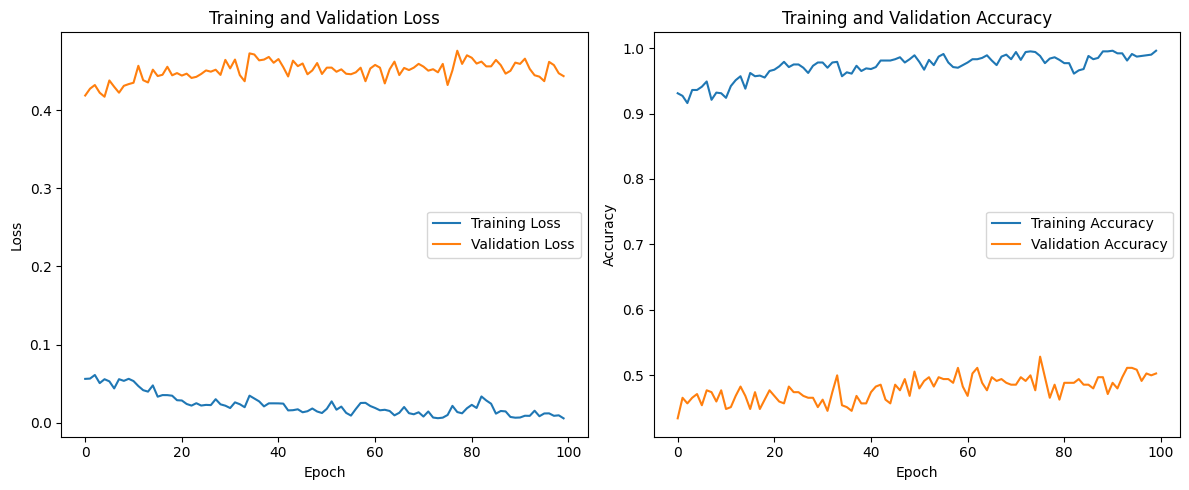

In [78]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

# Plot training & validation loss and accuracy values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()